In [1]:
import torch
import glob
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [113]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, error_bad_lines=False)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        label = int(label)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
res = 128
crop_size = 32
input_dim = (res,res)
input_size  = crop_size*crop_size   # images are 32x32 pixels
output_size = 2      # there are 10 classes

data_path = 'E:/Users/spectR/Desktop/%projects/summer2021/'
dataset_all = CustomImageDataset(
    annotations_file=f"{data_path}/input_labels35.csv",
    img_dir=data_path,
    transform=torchvision.transforms.Compose([
        #transforms.CenterCrop(crop_size),
        transforms.Resize((crop_size,crop_size)),
        transforms.ToTensor()
        #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ]),
    #target_transform=transforms.ToTensor()
    #target_transform=transforms.Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

dataset_size = len(dataset_all)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_all, [train_size, test_size])

def load_train_dataset():   
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle = True
    )
    return train_loader
def load_test_dataset():   
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        num_workers=0,
        shuffle = True
    )
    return test_loader

NameError: name 'CustomImageDataset' is not defined

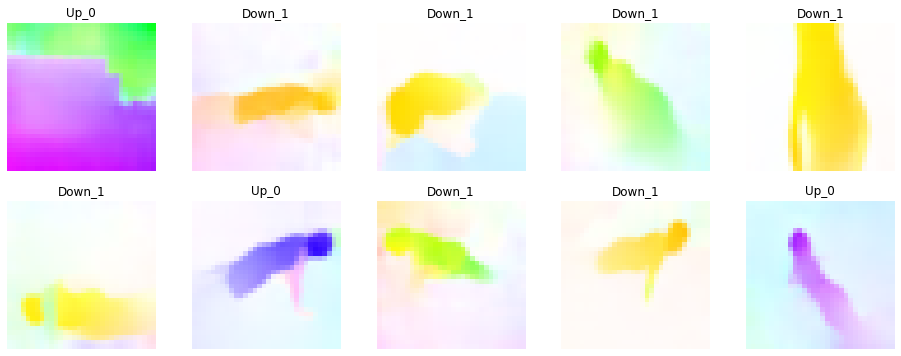

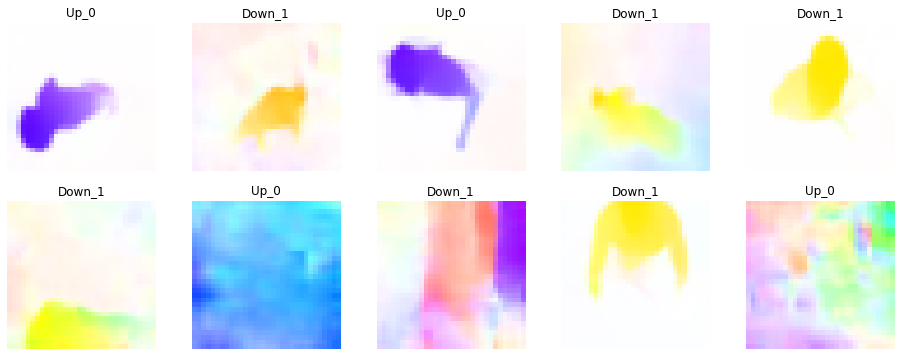

In [116]:
# show some images
fig = plt.figure(figsize=(16, 6))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    image, label = (load_train_dataset()).dataset.__getitem__(i)
    if label == 1:
        ax.set_title(f"Down_{label}")
    else:
        ax.set_title(f"Up_{label}")
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis('off');

fig = plt.figure(figsize=(16, 6))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    image, label = (load_test_dataset()).dataset.__getitem__(i)
    if label == 1:
        ax.set_title(f"Down_{label}")
    else:
        ax.set_title(f"Up_{label}")
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis('off');

In [10]:
'''
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.batchnorm = nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*15*15, 1)
        #self.fc2 = nn.Linear(12, 1)
        self.predict = nn.ReLU()
        
    def forward(self, x, verbose=True):
        # F here is the library of functionals
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = F.relu(x)
        x = x.view(-1, self.n_feature*15*15)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p = 0.2)
        x = self.predict(x)
        return x
'''
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*5*5, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        # F here is the library of functionals
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [120]:
train_features, train_labels = next(iter(load_train_dataset()))
train_labels = train_labels.to(torch.float32)
print(train_labels)
#for batch_idx, (data, target) in enumerate(load_train_dataset()):
#    print(target)

tensor([1.])


In [126]:
accuracy_list = []

def sigmoidLoss(output,target):
    loss = torch.nn.Sigmoid()
    return abs(2*loss(output)-target)

def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(load_train_dataset()):
        # send to device
        data, target = data.to(device), target.to(device)
        #print(data,target)
        target = target.to(torch.long)
        #target = target.view(-1,1)
        optimizer.zero_grad()
        output = model(data)
        #print(output, "\n",target)
        loss = F.nll_loss(output, target)
        #print("output",output)
        
        #loss = sigmoidLoss(output, target)
        #loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(load_train_dataset().dataset),
                100. * batch_idx / len(load_train_dataset()), loss.item()))
      

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in load_test_dataset():
        # send to device
        data, target = data.to(device), target.to(device)
        
        target = target.to(torch.long)
        #target = target.view(-1,1)
        output = model(data) 
        #test_loss += sigmoidLoss(output, target).item()
        #test_loss += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss                                                 
        test_loss += F.nll_loss(output, target, reduction='sum').item()      
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(load_test_dataset().dataset)
    accuracy = 100. * correct / len(load_test_dataset().dataset)
    accuracy_list.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(load_test_dataset().dataset),
        accuracy))
    
    

In [6]:
n_features = 16 # number of feature maps


In [135]:
# Training settings CNN
print(input_size, output_size)
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

print(model_cnn)
for epoch in range(0, 100):
    train(epoch, model_cnn)
    test(model_cnn)



1024 2
Number of parameters: 27784
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)
Train Epoch: 0 [0/1714 (0%)]	Loss: 0.704221

Test set: Average loss: 0.6632, Accuracy: 272/429 (63%)

Train Epoch: 1 [0/1714 (0%)]	Loss: 0.656367

Test set: Average loss: 0.2741, Accuracy: 396/429 (92%)

Train Epoch: 2 [0/1714 (0%)]	Loss: 0.181063

Test set: Average loss: 0.2285, Accuracy: 398/429 (93%)

Train Epoch: 3 [0/1714 (0%)]	Loss: 0.277297

Test set: Average loss: 0.1801, Accuracy: 407/429 (95%)

Train Epoch: 4 [0/1714 (0%)]	Loss: 0.228278

Test set: Average loss: 0.1657, Accuracy: 407/429 (95%)

Train Epoch: 5 [0/1714 (0%)]	Loss: 0.100442

Test set: Average loss: 0.1585, Accuracy: 407/429 (95%)

Train Epoch: 6 [0/1714 (0%)]	Loss: 0.195888

Test set: Average loss: 0.1660, Accuracy: 410/429 (96%)

Tra

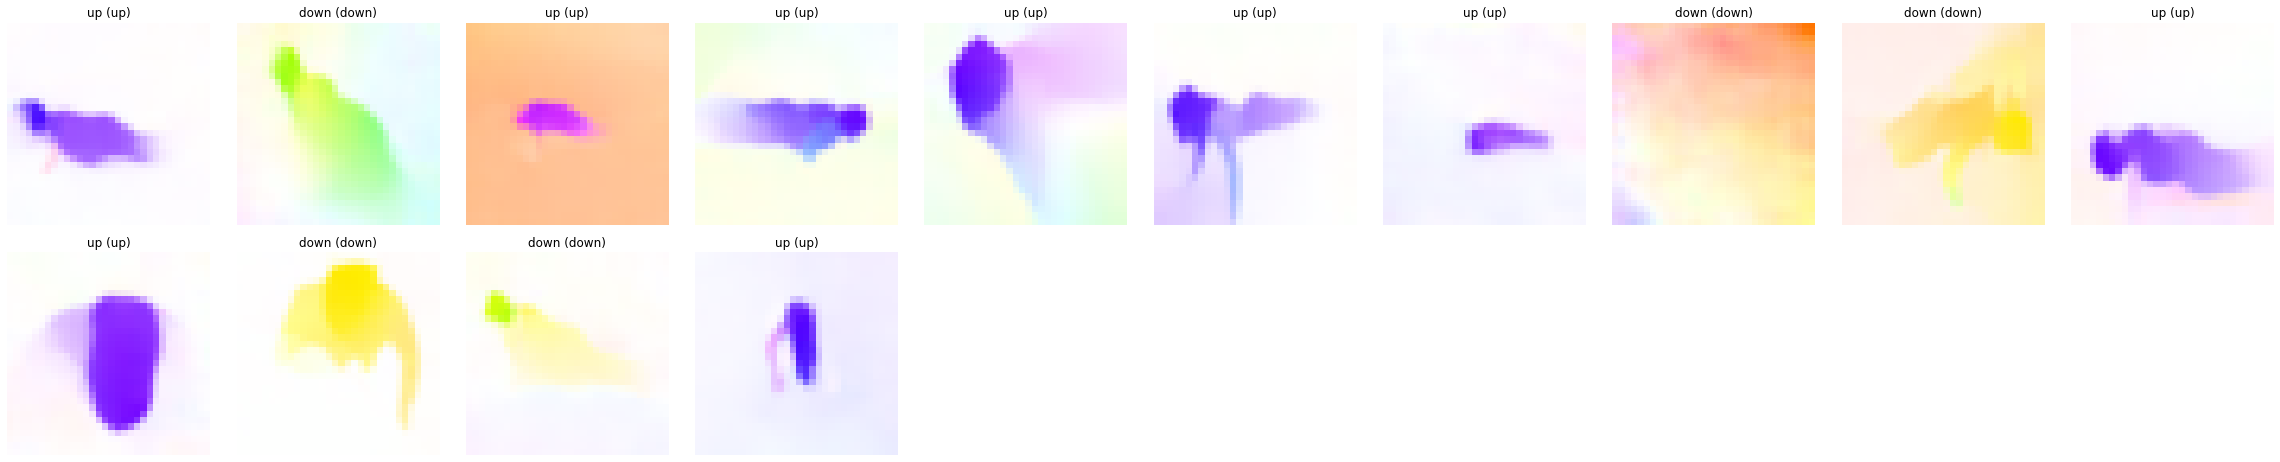

In [137]:
categories = ['up', 'down']

def show_predictions(rows=10, columns = 10):
    y_pred = []
    y_true = []
    x = []
    maxtoshow = rows * columns
    
    i = 0
    for data, target in load_test_dataset():
        if i>=maxtoshow:
            break
        data, target = data.to(device), target.to(device)
        output = model_cnn(data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        x.append(data.view(-1,3,32,32)[0].permute(1, 2, 0).cpu())
        y_pred.append(pred)
        y_true.append(target)
        i = i + 1
        

    ii = 0
    plt.figure(figsize=(32, 32))
    for i in range(len(x)):
        if ii>=maxtoshow:
            break
        plt.subplot(rows, columns, ii+1)
        plt.axis('off')
        plt.imshow(x[i].numpy())
        plt.title("%s (%s)" % (categories[y_pred[i][0]], categories[y_true[i][0]]))
        ii = ii + 1
    plt.tight_layout()

show_predictions()

In [13]:
PATH = "E:/Users/spectR/Desktop/%projects/push-up-counter/cnn_model1.pth"
#torch.save(model_cnn.state_dict(), PATH)

In [42]:

def eval(path, v = False):
    model = CNN(input_size, n_features, output_size)  # Initialize model
    model.load_state_dict(torch.load(PATH))  # Load pretrained parameters
    model.eval()  # Set to eval mode to change behavior of Dropout, BatchNorm

    transform = torchvision.transforms.Compose([
            transforms.Resize((crop_size,crop_size)),
            transforms.ToTensor()
            ])  # Same as for your validation data, e.g. Resize, ToTensor, Normalize, ...

    img = Image.open(path)  # Load image as PIL.Image
    x = transform(img)  # Preprocess image
    #x = x.to(device)
    x = x.unsqueeze(0)  # Add batch dimension

    output = model(x)  # Forward pass
    #print(output)
    pred = torch.argmax(output, 1)  # Get predicted class if multi-class classification

    if torch.tensor([1]).eq(pred):
        if v:
            print('Image predicted as Down')
        return (1, output)
    else:
        if v:
            print('Image predicted as Up')
        return (0, output)


In [27]:
eval("E:/Users/spectR/Desktop/%projects/push-up-counter/input_transformed/RAFT_flow/pushup067/frame_0031.png", True)

tensor([[-0.0173, -4.0646]], grad_fn=<LogSoftmaxBackward>)
Image predicted as Up


0

In [ ]:
0 up 1 down

In [43]:
inputs = glob.glob('validation_transformed/RAFT_flow/pushup001/*')
#writer = pd.ExcelWriter('val1.xlsx', engine='xlsxwriter')
df = pd.DataFrame()
i = 0
for input_path in inputs:
    input_path = input_path.replace("\\","/")
    df.loc[i,0] = input_path
    pred = eval(input_path, False)
    df.loc[i,1] = pred[0]
    df.loc[i,2] = pred[1].detach().numpy()[0][0]
    df.loc[i,3] = pred[1].detach().numpy()[0][1]
    i+=1
df.to_csv('val1.csv', header = False, index= False)